In [56]:
# Imports
%matplotlib inline
import quandl
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from datetime import datetime, timedelta
from collections import defaultdict
import matplotlib.pyplot as plt

In [166]:
PERIODS = 12
DAYS_BETWEEN = 30

In [146]:
# Get price data from Quandl
bitcoin = quandl.get("BCHAIN/MKPRU")
bitcoin = bitcoin.loc['2011-01-01':] # Remove the 0's
bitcoin.dropna(inplace=True)
bitcoin.columns = ['Last']

In [12]:
def buy_all_now_return(d):
    '''d is the date that you are buying'''
    price_today = bitcoin.loc[d,'Last']
    ret = bitcoin['Last'].iloc[-1] / price_today - 1
    return ret

In [174]:
buy_all_now_return('2018-01-01')

-0.6457257588675362

In [276]:
def dollar_cost_average_return(d, periods=PERIODS, freq= str(DAYS_BETWEEN) + 'D'):
    '''spread your purchase over the next period months from date d'''
    buy_dates = pd.date_range(start=d, periods=periods, freq=freq)
    buy_dates = [i for i in buy_dates if i < bitcoin.index[-1]] # remove dates in the future
    if len(buy_dates) < 2:
        print "Error"
    return np.mean([buy_all_now_return(d) for d in buy_dates])

In [178]:
dollar_cost_average_return('2018-01-01')

-0.3125103673158862

In [278]:
a = []
end_date = (datetime.now() - timedelta(days=PERIODS * DAYS_BETWEEN))#.strftime('%Y-%m-%d') 
end_date = (datetime.now() - timedelta(days=1 * DAYS_BETWEEN + 1))#.strftime('%Y-%m-%d') 
#data = bitcoin.loc[:end_date].copy()

for d, row in bitcoin.iterrows():
    if d < end_date:
        bn = buy_all_now_return(d)
        dca = dollar_cost_average_return(d)
        if dca>bn:
            a.append('green')
        else:
            a.append('red')
    else:
        a.append('gray')

bitcoin['color'] = a

In [279]:
bitcoin['color'].value_counts()

red      2006
green     979
gray       31
Name: color, dtype: int64

In [280]:
days_dca_better = float(bitcoin['color'].value_counts()[1]) / (len(bitcoin) - PERIODS * DAYS_BETWEEN) * 100
print "Dollar cost averaging is better %0.2f%% of the time" % days_dca_better

Dollar cost averaging is better 36.86% of the time


In [281]:
bitcoin['red'] = np.where(bitcoin['color'] == 'red', bitcoin['Last'], np.NAN)
bitcoin['gray'] = np.where(bitcoin['color'] == 'gray', bitcoin['Last'], np.NAN)

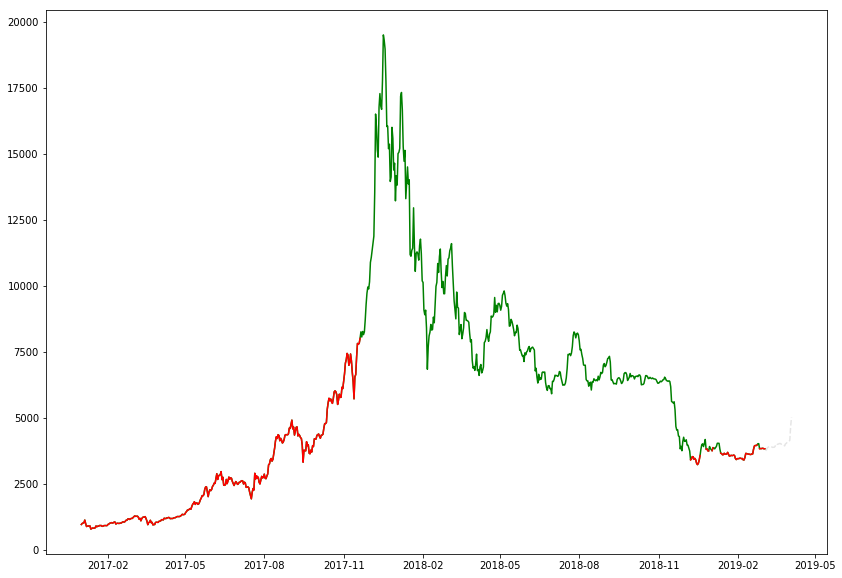

In [282]:
plt.figure(figsize=(14,10))
subset = bitcoin.loc['2017':]

plt.plot(subset['Last'].loc[:end_date], color='green')
plt.plot(subset['red'], color='red');
plt.plot(subset['gray'],color='gray', linestyle='dashed', alpha=0.2);

In [215]:
from bokeh.plotting import figure, output_file, show

output_file("dollar_cost_averaging.html")

p = figure(plot_width=1000, plot_height=600, x_axis_type="datetime")

p.line(d['Last'].index, d['Last'], color="green", alpha=0.5, line_width=2)
p.line(d['red'].index, d['red'], color="red", alpha=0.5, line_width=2)

show(p)